In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data, filters, feature, morphology,io, measure, exposure, draw
from skimage.metrics import mean_squared_error
import imutils
import argparse

In [17]:
def show_image(image, gray=True, BGR=True):
    out = image.copy()
    if gray == True:
        plt.imshow(image, cmap="gray")
    else:
        if BGR:
            out = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(out)
    plt.show()


In [18]:
#Colors and value decisions

def coin_decision(avg, avg_ctr):
    if avg <= 100:
        return "1"
    else:
        return coin_conflict(avg_ctr)

def coin_conflict(avg):
    if avg <= 130:
        return "2"
    else:
        return "5"

def coin_color(decision):
    if decision == 5:
        return (0,255,0)
    elif decision == 2:
        return (255,0,0)
    else:
        return (0,0,255)
    

def find_color(money):
    if (money == 10.00):
        color = (114, 97, 68)
    elif (money == 20.00):
        color = (128, 107, 59)
    elif (money == 50.00):
        color = (142, 161, 226)
    elif (money == 100.00):
        color = (115, 175, 114)
    return color[::-1]

In [19]:
# Circles function

def calculate_average_distance(image):
    distance_list = []
    for row in image:
        for (b, g, r) in row:
            if(b != 0 and g != 0 and r != 0):
                
                # Calculate distance
                value = abs(int(b) - int(g)) + abs(int(b) - int(r)) + abs(int(r) - int(g))

                # Append calculated value
                distance_list.append(value)

    # Cast list to numpy array
    distance_list = np.array(distance_list, dtype="int")

    # Calculate average
    avg = np.average(distance_list)
    return avg


def contours(img):
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11,11), 0)
    
    _, thresh = cv2.threshold(blur,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=2)
    dilated = cv2.dilate(eroded, kernel, iterations=2)
    
    contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, 
                                       cv2.CHAIN_APPROX_NONE)

    cnts = imutils.grab_contours(contours)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    return img_color, cnts



def cut(img, cnts):
    imgs = []
    centers = []
    text = []
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for cnt in cnts:
        mask = np.zeros(gray.shape, np.uint8)
        new = cv2.drawContours(mask, [cnt], 0, 255, -1)
        new = cv2.bitwise_and(img, img, mask=mask)
        
        M = cv2.moments(cnt)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        (x,y) = np.where(mask==255)
        (x1,y1) = (np.min(x), np.min(y))
        (x2,y2) = (np.max(x), np.max(y))
        crop_img = img[x1:x2+1, y1:y2+1]
        
        x1 = int(crop_img.shape[0] / 4)
        x2 = int(3 * crop_img.shape[0] / 4)
        y1 = int(crop_img.shape[1] / 4)
        y2 = int(3 * crop_img.shape[1] / 4)
        
        centrum = crop_img[x1:x2, y1:y2]
        
        imgs.append(crop_img)
        centers.append(centrum)
        text.append((cX, cY))
        
    return imgs, centers, text


def f_circle(img, cnts):
    ctr = []
    i=0
    for cnt in cnts:
                    approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
                    vert = len(approx)
                    if(3 < vert):
                        area = cv2.contourArea(cnt)
                        #print(area,i)
                        i+=1
                        if (500 < area <200000):
                            _, r = cv2.minEnclosingCircle(cnt)
                            r = r * 0.95
                            circleArea = r * r * np.pi
                            if(area/circleArea > 0.60):
                                ctr.append(cnt)

    return ctr


def circle(img, cnts):
    circles = f_circle(img,cnts)
    
    imgs, centers, text  = cut(img, circles)
    
    suma = [0]
    for j in range(len(imgs)):
        avg = calculate_average_distance(imgs[j])
        #print("Avg", avg)
        
        center_avg = calculate_average_distance(centers[j])
        #print("Avg_ctr", center_avg)
        
        dec = int(coin_decision(avg, center_avg))
        #print("Moneta", decyzja)
        
        suma.append(dec)
        
        cv2.drawContours(img, circles[j], -1, coin_color(dec), 5)
        cv2.putText(img, str(dec)+" PLN", text[j], cv2.FONT_HERSHEY_SIMPLEX, 1.2, coin_color(dec), 2)
    
    return suma

In [20]:
# Rectangles function
def load_templates(paths):
    templates = []
    for path in paths:
        img_rgb = cv2.imread(path)
        img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (30,70), interpolation = cv2.INTER_AREA)
        templates.append({'val': path, 'img': img})
    return templates

def image_rotate(image, n):
    rotated = imutils.rotate_bound(image, n)
    return rotated


def intersection_boolean_2(a, b):
    X = a[0] + a[2] / 2
    Y = a[1] + a[3] / 2
    if X < (b[0] + b[2]) and X > b[0] and Y > b[1] and (Y < b[1] + b[3]):
        return True
    else:
        return False


def find_rectangle(img):
    max_area = (img.shape[0] - 15) * (img.shape[1] - 15)
    img = cv2.GaussianBlur(img, (15, 15), 0)
    cons = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 5):
            if thrs == 0:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (17, 17), 0)

            ret2, thresh2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            ret, thresh = cv2.threshold(blur, ret2, 255, cv2.THRESH_BINARY_INV)
            canny = cv2.Canny(thresh, 40, 160)  # 40 160
            dilated = cv2.dilate(canny, (1, 1), iterations=2)

            contours, _hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            for cnt in contours:
                cnt_rare = cnt.copy()
                flag_intersection = False
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02 * cnt_len, True)
                if len(cnt) > 3 and len(cnt) < 15 and cv2.contourArea(
                        cnt) > 40000 and cnt.all() != 0 and cv2.isContourConvex(cnt):

                    x, y, width, height = cv2.boundingRect(cnt)
                    r1 = (x, y, width, height);
                    for r in cons:  # for every rectangle in results check that another rectangle intersection with it. If yes then skip it
                        xr, yr, widthr, heightr = cv2.boundingRect(r)
                        r2 = (xr, yr, widthr, heightr);
                        if intersection_boolean_2(r1, r2):
                            flag_intersection = True
                            break

                    if (flag_intersection == False):
                        cons.append(cnt_rare)
    return cons

def resize_master(banknote, image):
    x, y, width, height = cv2.boundingRect(banknote)

    banknote_image = image[y: y + height, x: x + width].copy()
    rect = cv2.minAreaRect(banknote)
    
    
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    center, size, angle = rect
    # grab the dimensions of the image and then determine the center
    (h, w) = banknote_image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
       
    
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    dst = cv2.warpAffine(banknote_image, M, (nW, nH))
    out = cv2.getRectSubPix(dst, (int(size[0]), int(size[1])), (nW//2, nH//2))
    if out.shape[0]> out.shape[1]:
        out = image_rotate(out, 90)
    out = cv2.resize(out, (400,200))
    return out 
    
def banknote_finalizing(rectangle,banknote_image, templates):
    img = rectangle
    x, y, width, height = cv2.boundingRect(img)
    rx = x
    ry = y
    rw = width
    rh = height
    find_numbers(banknote_image, templates)
    return decision, money, width, height, x, y

def to_rotation(banknote, gray):
    out = banknote.copy()[25:40,35:45]
    contours = measure.find_contours(out)
    if contours == []: 
        
        wyjscie = image_rotate(banknote, 180)
        gray_out = image_rotate(gray, 180)
    else:
        wyjscie = banknote
        gray_out = gray
    return wyjscie , gray_out
    

def find_numbers(banknote_rotated, templates):
    is_number = False
    value = None 
    decision = None 
    gray = cv2.cvtColor(banknote_rotated, cv2.COLOR_RGB2GRAY)
    banknote = cv2.GaussianBlur(gray, (5, 5), 0)
    banknote = exposure.adjust_gamma(banknote, gamma=0.7)
    banknote = cv2.Canny(banknote, 100, 100)
    banknote = morphology.dilation(banknote)
    banknote = morphology.dilation(banknote)
    banknote, gray = to_rotation(banknote, gray)
    for i in range(1):
        if is_number == True:
            break 
        else:
            contours = measure.find_contours(banknote)
            for contour in contours:
                cords = measure.approximate_polygon(contour, tolerance=2.5)
                rr, cc = draw.polygon(cords[:, 1], cords[:, 0], shape=None)
                if rr.size > 0 and cc.size > 0:
                    (x, y, w, h) = cv2.boundingRect(np.array([[min(rr), min(cc)], [max(rr), max(cc)]]))
                    if w < 60 and w > 40 and h > 60 and h < 100 and x < 40 and y < 40 :
                        print(x, y, w, h)
                        with_numbers = cv2.rectangle(banknote_rotated, (x, y), (x + w, y + h), (255, 255, 0), 2)
                        to_decize = gray[y:y + h, x:x + w]
                        to_decize = cv2.Canny(to_decize, 100, 100)
                        to_decize = morphology.dilation(to_decize)
                        to_decize = cv2.resize(to_decize, (30, 70), interpolation=cv2.INTER_AREA)
                        is_number = True
    if is_number == True:
        matching = [0 for _ in templates]
        for index, template in enumerate(templates):
            matching[index] = mean_squared_error(to_decize, template['img'])
        value = int(templates[np.argmin(matching)]['val'].split('.')[0])
        decision = str(templates[np.argmin(matching)]['val'].split('.')[0]) + str(' PLN')
        print('value',value, '   decision', decision)
    return value, decision

def rectangle(img,templates):
    image = img
    
    suma = [0]
    output = image.copy()

    rx = None
    ry = None
    rw = None
    rh = None

    # Find banknotes
    banknote_image = image.copy()
    cons = find_rectangle(banknote_image)
    for i in range(len(cons)):
        rotated  = resize_master(cons[i], banknote_image)
        money, decision = find_numbers(rotated, templates)
        x, y, width, height = cv2.boundingRect(cons[i])
        if money != None:
            cv2.drawContours(output, cons[i], -1, find_color(money), 25)
            cv2.putText(output, "{:.2f} PLN".format(money), (int(x + width / 2), int(y + height / 2)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
            suma.append(money)
        
    
    return suma, output

In [21]:
def total_cost(sum1,sum2):
    suma = 0
    for i in range(len(sum1)):
        suma += sum1[i]
    for j in range(len(sum2)):
        suma += sum2[j]
    
    return suma

14 17 48 73
value 50    decision 50 PLN


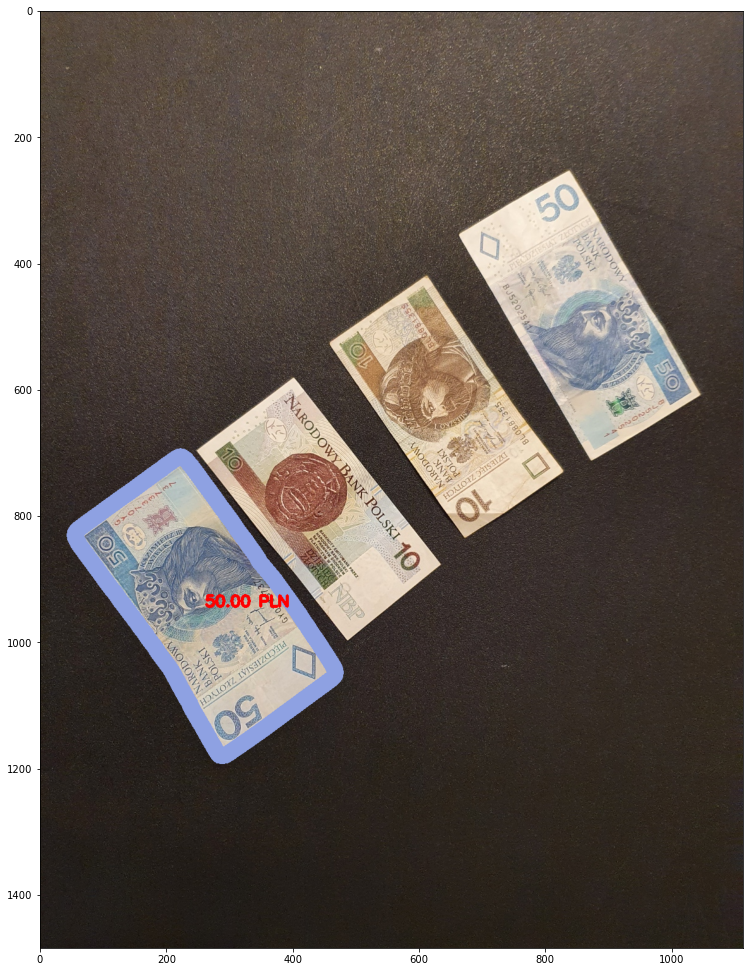

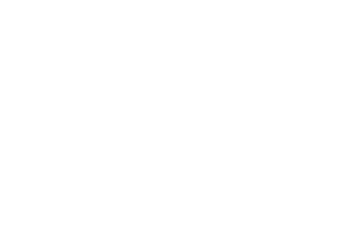

In [24]:
# Main

#tab = ["c1.jpg","c2.jpg","c3.jpg","c4.jpg", "c5.jpg"]
#tab = ["m1.jpg","m2.jpg","m3.jpg","m4.jpg","m5.jpg",
#       "m6.jpg","m7.jpg","m8.jpg","m9.jpg","m10.jpg",
#       "m11.jpg","m12.jpg","m13.jpg","m14.jpg","m15.jpg",
#       "m16.jpg","m17.jpg","m18.jpg","m19.jpg","m20.jpg"]
#tab = ["b1.jpg","b2.jpg","b3.jpg","b4.jpg", "b5.jpg"]
tab = ["b2.jpg"]
templates = load_templates(['10.jpg','20.jpg','50.jpg','100.jpg'])
#tab = ["mix1.jpg","mix2.jpg","mix3.jpg","mix4.jpg", "mix5.jpg"]
#tab = ["all1.jpg","all2.jpg","all3.jpg","all4.jpg", "all5.jpg"]
#tab = ["picture_002.jpg"]
fig = plt.figure(figsize = (100,100))

for i in range(len(tab)):
    img = cv2.imread(tab[i])
    
#Circles    
    #img, cnts = contours(img)
    
    #circle_sum = circle(img, cnts)  
    
# Rectangles
    rectangle_sum, img = rectangle(img,templates)
    

    #total = total_cost(rectangle_sum)
    
    #cv2.putText(img, "Total cost: "+str(total)+" PLN", (70,125), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 5)
       
    fig.add_subplot(5, 1, i + 1)
    show_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
fig.tight_layout()